# Bayesian Spatiotemporal Modeling
This notebook demonstrates Bayesian modeling for spatiotemporal data using PyMC.

**Outline:**
1. Import Required Libraries
2. Load and Preprocess Spatiotemporal Data
3. Define Bayesian Spatiotemporal Model
4. Fit Model Using MCMC Sampling
5. Visualize Posterior Estimates
6. Make Predictions on New Data

In [13]:
# 1. Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

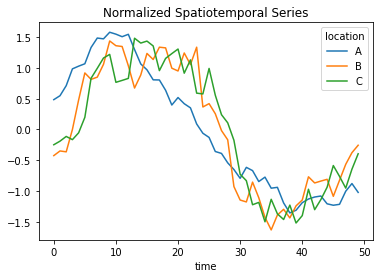

In [14]:
# 2. Load and Preprocess Spatiotemporal Data
np.random.seed(42)
T = 50
locations = ['A', 'B', 'C']
data = []
for loc in locations:
    y = np.cumsum(np.random.randn(T)) + 5*np.sin(np.linspace(0, 2*np.pi, T))
    data.append(pd.DataFrame({'time': np.arange(T), 'location': loc, 'value': y}))
df = pd.concat(data)
df_pivot = df.pivot(index='time', columns='location', values='value')
# Ensure numeric dtype and avoid division by zero
df_pivot = df_pivot.apply(lambda col: (col - col.mean()) / (col.std() if col.std() > 0 else 1))
df_pivot.plot(title="Normalized Spatiotemporal Series")
plt.show()

In [16]:
# 3. Define Bayesian Spatiotemporal Model
coords = {'location': locations, 'time': np.arange(T)}
with pm.Model(coords=coords) as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    phi = pm.Normal('phi', mu=0, sigma=0.5)
    y = pm.MutableData('y', df_pivot.values)
    # AR(1) process for all locations (vectorized)
    value = pm.Normal('value', mu=mu, sigma=sigma, shape=(T, len(locations)))
    ar1_logp = 0
    for loc in range(len(locations)):
        rv = pm.Normal.dist(mu=phi * value[:-1, loc], sigma=sigma)
        ar1_logp += pm.logp(rv, value[1:, loc]).sum()
    pm.Potential('ar1_process', ar1_logp)
    obs = pm.Normal('obs', mu=value, sigma=0.1, observed=y)

In [17]:
# 4. Fit Model Using MCMC Sampling
with model:
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, phi, value]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


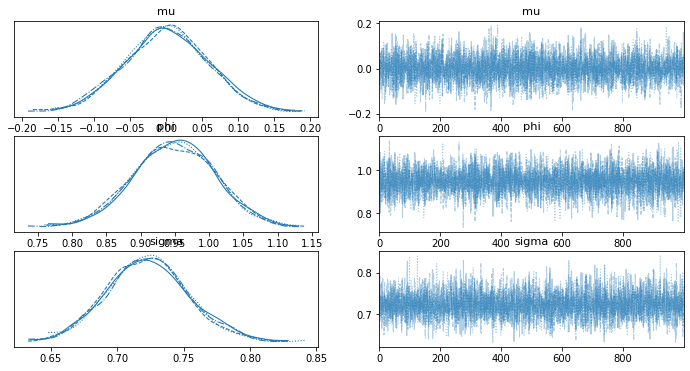

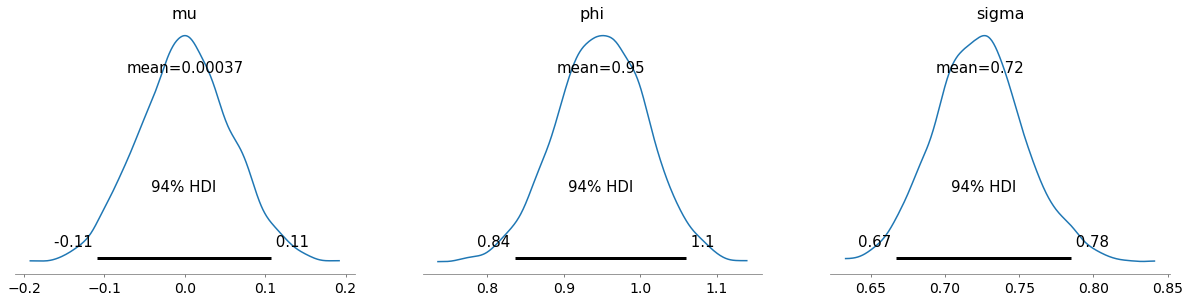

In [18]:
# 5. Visualize Posterior Estimates
az.plot_trace(trace, var_names=['mu', 'phi', 'sigma'])
plt.show()
az.plot_posterior(trace, var_names=['mu', 'phi', 'sigma'])
plt.show()

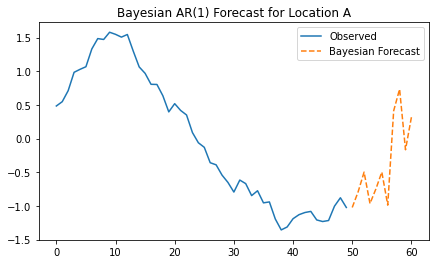

In [19]:
# 6. Make Predictions on New Data
# For demonstration, predict next 10 time points for location 'A'
phi_post = trace.posterior['phi'].mean().item()
sigma_post = trace.posterior['sigma'].mean().item()
last_value = df_pivot['A'].iloc[-1]
preds = [last_value]
for i in range(10):
    next_val = phi_post * preds[-1] + np.random.normal(0, sigma_post)
    preds.append(next_val)
plt.figure(figsize=(7,4))
plt.plot(df_pivot['A'].index, df_pivot['A'], label='Observed')
plt.plot(np.arange(T, T+11), preds, '--', label='Bayesian Forecast')
plt.legend()
plt.title('Bayesian AR(1) Forecast for Location A')
plt.show()